In [1]:
import json
from collections import defaultdict
from datetime import datetime, timedelta

import backoff
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import web3
from tqdm.notebook import tqdm
from web3.middleware import geth_poa_middleware

from generation import extract_params, PriceFeed

In [2]:
provider = web3.Web3.HTTPProvider('<insert endpoint here>')
w3 = web3.Web3(provider)
w3.middleware_onion.inject(geth_poa_middleware, layer=0)

In [3]:
interval = 2.2 # 2.2 seconds
hour_interval = int(60 * 60 / interval)

In [4]:
with open('abi.json', 'r') as file:
    abi = file.read()

In [5]:
oracles = {
    'USDC': '0xfE4A8cc5b5B2366C1B58Bea3858e81843581b2F7',
    'ETH': '0xF9680D99D6C9589e2a93a78A04A279e509205945',
    'USDT': '0x0A6513e40db6EB1b165753AD52E80663aeA50545',
    'DAI': '0x4746DeC9e833A82EC7C2C1356372CcF2cfcD2F3D',
    'BTC': '0xc907E116054Ad103354f2D350FD2514433D57F6f',
    'stMATIC': '0x97371dF4492605486e23Da797fA68e55Fc38a13f',
    'wstETH': '0x10f964234cae09cB6a9854B56FF7D4F38Cda5E6a',
    'MATIC': '0xAB594600376Ec9fD91F8e885dADF0CE036862dE0',
}

## Extract distribution parameters

In [6]:
decimals = {}

for token, oracle in oracles.items():
    decimals[token] = w3.eth.contract(
        address=oracle,
        abi=abi,
    ).functions.decimals().call()

In [7]:
with open('collected.json', 'r') as file:
    prices = json.load(file)

In [8]:
blocks = list(sorted(int(x) for x in prices.keys()))
starting_ts = w3.eth.get_block(blocks[0])
ts = [
    datetime.fromtimestamp(starting_ts.timestamp) + timedelta(seconds=int(interval * (x - blocks[0])))
    for x in blocks
]

In [9]:
for block in blocks:
    tokens = prices[str(block)].keys()
    for token in tokens:
        prices[str(block)][token] /= 10 ** decimals[token]

In [10]:
for block in blocks:
    prices[str(block)]['wstETH'] *= prices[str(block)]['ETH']

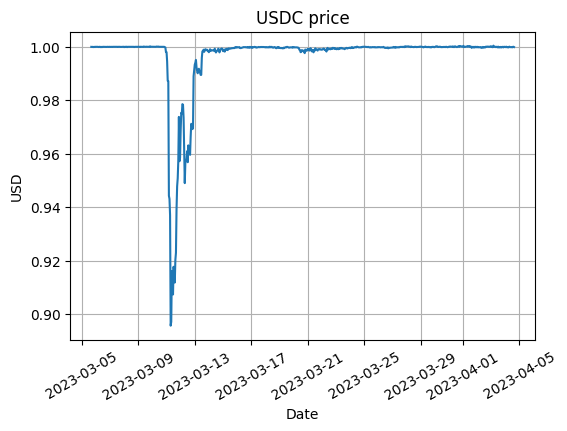

In [11]:
plt.figure(figsize=(6, 4))
plt.title('USDC price')
plt.plot(ts, [prices[str(x)]['USDC'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

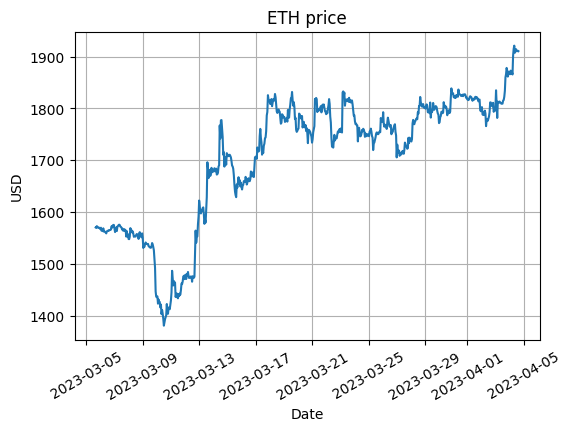

In [12]:
plt.figure(figsize=(6, 4))
plt.title('ETH price')
plt.plot(ts, [prices[str(x)]['ETH'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

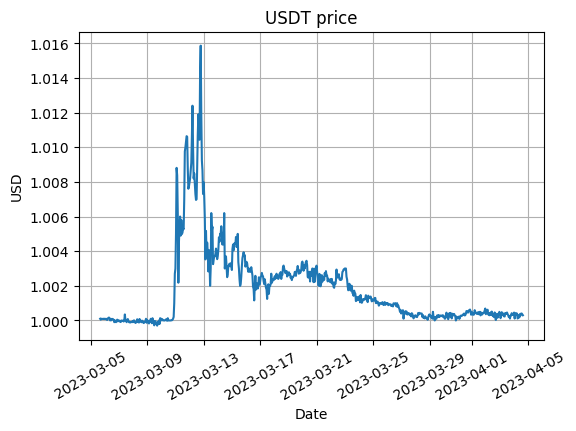

In [13]:
plt.figure(figsize=(6, 4))
plt.title('USDT price')
plt.plot(ts, [prices[str(x)]['USDT'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

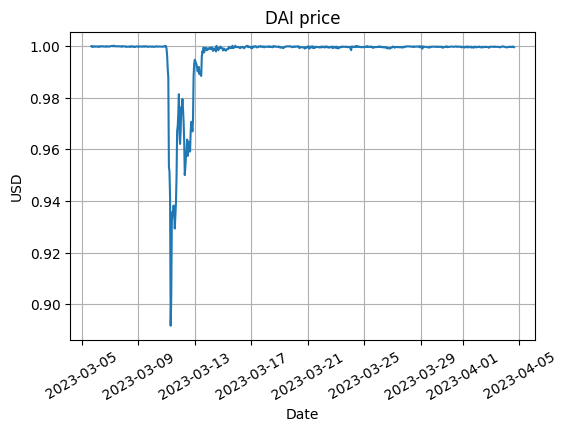

In [14]:
plt.figure(figsize=(6, 4))
plt.title('DAI price')
plt.plot(ts, [prices[str(x)]['DAI'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

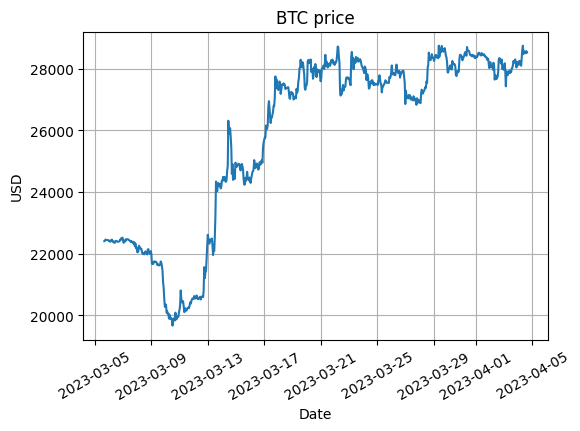

In [15]:
plt.figure(figsize=(6, 4))
plt.title('BTC price')
plt.plot(ts, [prices[str(x)]['BTC'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

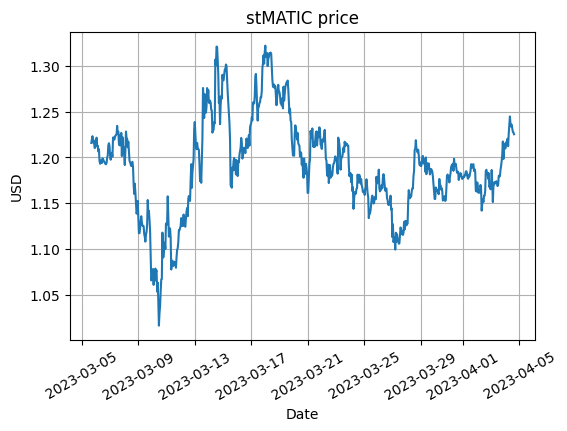

In [16]:
plt.figure(figsize=(6, 4))
plt.title('stMATIC price')
plt.plot(ts, [prices[str(x)]['stMATIC'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

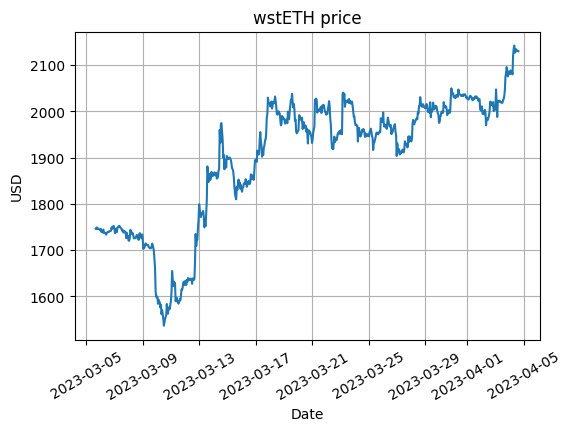

In [17]:
plt.figure(figsize=(6, 4))
plt.title('wstETH price')
plt.plot(ts, [prices[str(x)]['wstETH'] for x in blocks])
plt.xticks(rotation=30)
plt.xlabel('Date')
plt.ylabel('USD')
plt.grid()
plt.show()

In [18]:
tokens = sorted(list(prices[str(blocks[0])].keys()))

In [19]:
means, covariations = extract_params(
    np.array(
        [[prices[str(block)][token] for block in blocks[250:]] for token in tokens]
    )
)
np.save('means', means)
np.save('covariations', covariations)

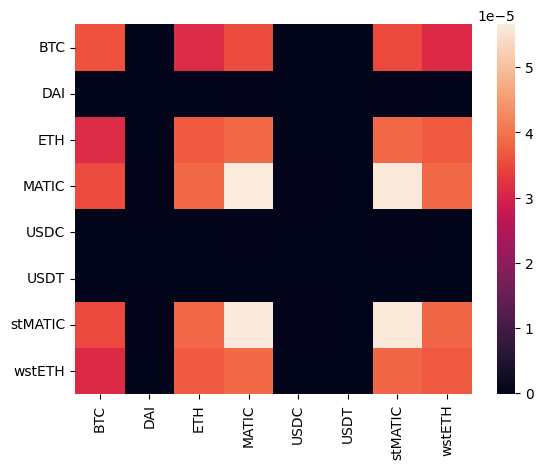

In [20]:
sns.heatmap(covariations, xticklabels=tokens, yticklabels=tokens);

In [21]:
starting_values = np.array([prices[str(blocks[0])][token] for token in tokens]).reshape(-1, 1)

tokens

['BTC', 'DAI', 'ETH', 'MATIC', 'USDC', 'USDT', 'stMATIC', 'wstETH']

In [22]:
prices_diff = np.vstack([np.diff(np.log([prices[str(block)][token] for block in blocks])) for token in tokens])

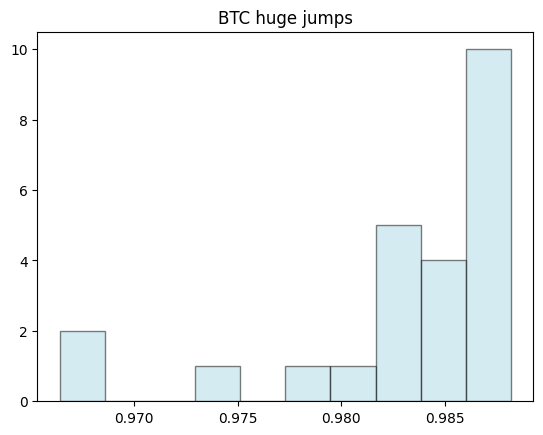

In [23]:
idx = 0
plt.title(tokens[idx] + ' huge jumps')
mask = (means[idx] - prices_diff[idx] > 2 * np.sqrt(covariations[idx][idx]))
values = prices_diff[idx][mask]
plt.hist(np.exp(values), color='lightblue', alpha=0.5, edgecolor='black');

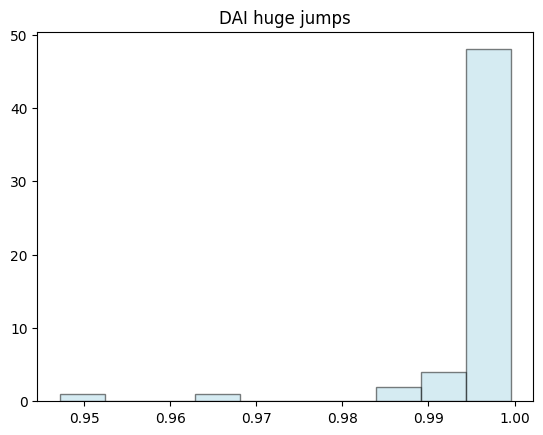

In [24]:
idx = 1
plt.title(tokens[idx] + ' huge jumps')
mask = (means[idx] - prices_diff[idx] > 2 * np.sqrt(covariations[idx][idx]))
values = prices_diff[idx][mask]
plt.hist(np.exp(values), color='lightblue', alpha=0.5, edgecolor='black');

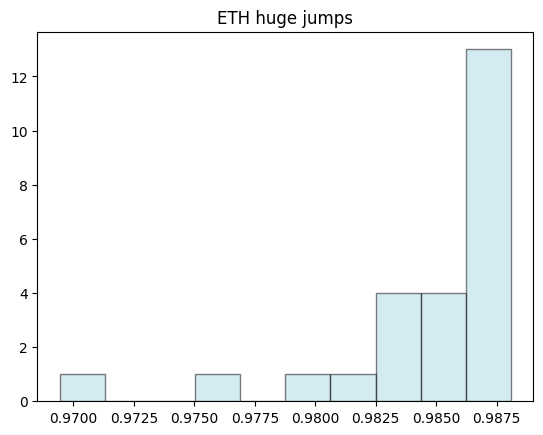

In [25]:
idx = 2
plt.title(tokens[idx] + ' huge jumps')
mask = (means[idx] - prices_diff[idx] > 2 * np.sqrt(covariations[idx][idx]))
values = prices_diff[idx][mask]
plt.hist(np.exp(values), color='lightblue', alpha=0.5, edgecolor='black');

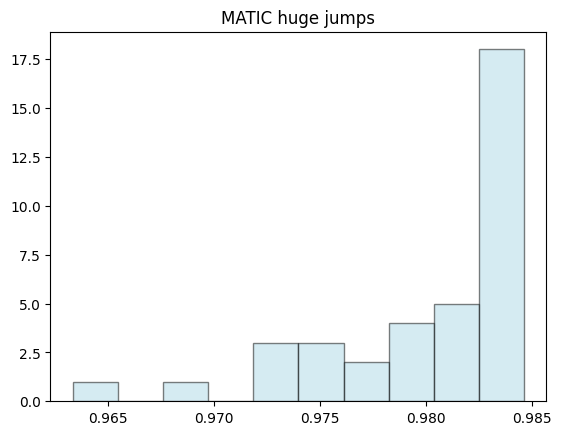

In [26]:
idx = 3
plt.title(tokens[idx] + ' huge jumps')
mask = (means[idx] - prices_diff[idx] > 2 * np.sqrt(covariations[idx][idx]))
values = prices_diff[idx][mask]
plt.hist(np.exp(values), color='lightblue', alpha=0.5, edgecolor='black');

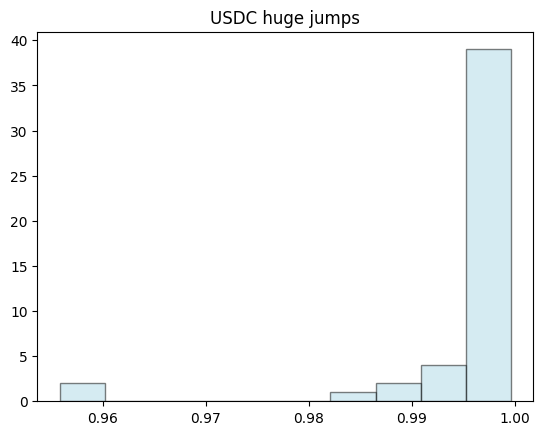

In [27]:
idx = 4
plt.title(tokens[idx] + ' huge jumps')
mask = (means[idx] - prices_diff[idx] > 2 * np.sqrt(covariations[idx][idx]))
values = prices_diff[idx][mask]
plt.hist(np.exp(values), color='lightblue', alpha=0.5, edgecolor='black');

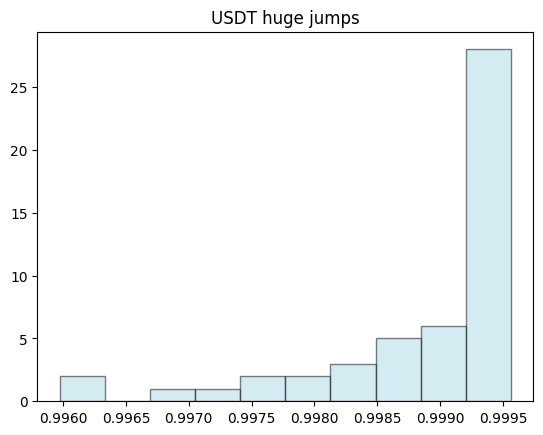

In [28]:
idx = 5
plt.title(tokens[idx] + ' huge jumps')
mask = (means[idx] - prices_diff[idx] > 2 * np.sqrt(covariations[idx][idx]))
values = prices_diff[idx][mask]
plt.hist(np.exp(values), color='lightblue', alpha=0.5, edgecolor='black');

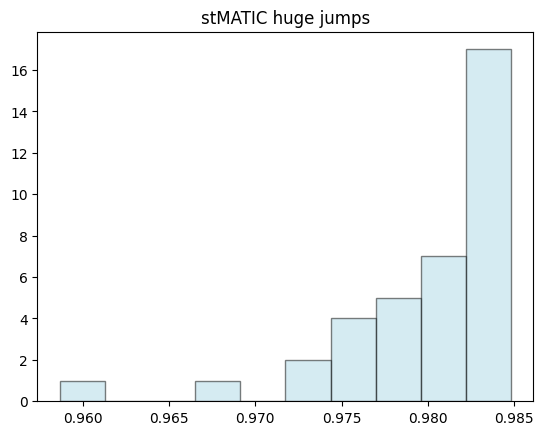

In [29]:
idx = 6
plt.title(tokens[idx] + ' huge jumps')
mask = (means[idx] - prices_diff[idx] > 2 * np.sqrt(covariations[idx][idx]))
values = prices_diff[idx][mask]
plt.hist(np.exp(values), color='lightblue', alpha=0.5, edgecolor='black');

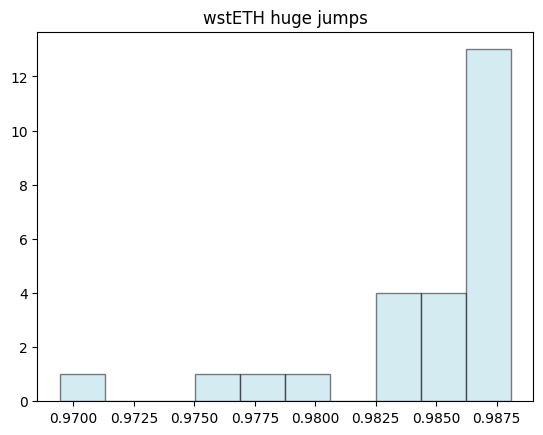

In [30]:
idx = 7
plt.title(tokens[idx] + ' huge jumps')
mask = (means[idx] - prices_diff[idx] > 2 * np.sqrt(covariations[idx][idx]))
values = prices_diff[idx][mask]
plt.hist(np.exp(values), color='lightblue', alpha=0.5, edgecolor='black');

In [31]:
with open('config.json', 'r') as file:
    config = json.load(file)

jumps = [[float(x['value']) for x in config['jumps'][token]] + [1] for token in tokens]
jump_probs = [[float(x['probability']) for x in config['jumps'][token]] + [1 - sum(float(x['probability']) for x in config['jumps'][token])] for token in tokens]
jump_recoveries = [config['jump_recoveries'][token] for token in tokens]

In [32]:
n_samples=100

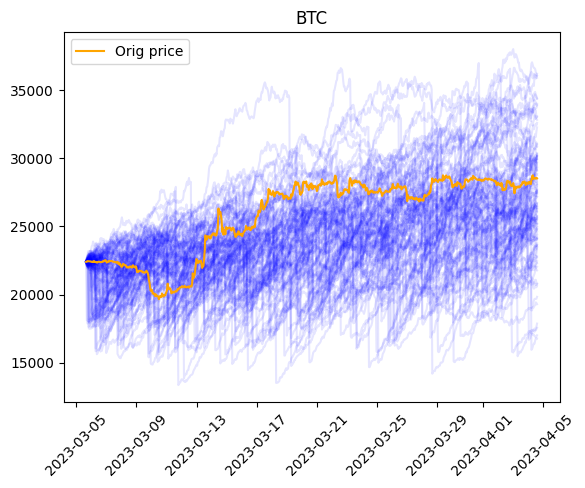

In [33]:
idx = 0
plt.title(list(tokens)[idx])
feed = PriceFeed(
    means[idx:idx + 1],
    covariations[idx:idx + 1, idx:idx + 1],
    np.ones((1, n_samples)) * prices[str(blocks[0])][tokens[idx]],
    jumps[idx:idx + 1], jump_probs[idx:idx + 1],
#     [1, 1, 1, 1, 1, 1, 1],
    jump_recoveries[idx:idx + 1],
)
values = [feed.current_state]
for _ in range(len(blocks) - 1):
    feed.next_step()
    values.append(feed.current_state)
plt.plot(ts, np.vstack(values), alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

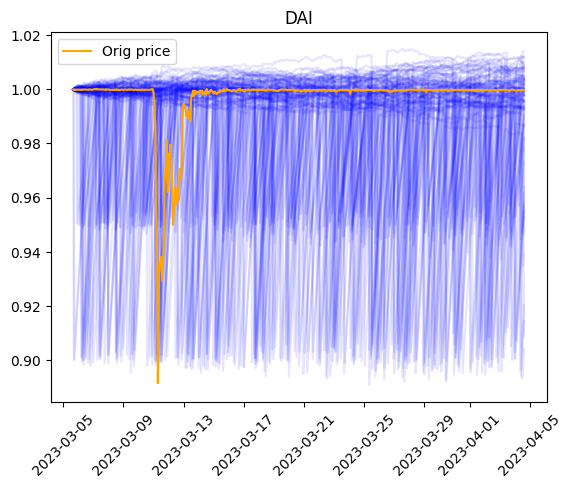

In [34]:
idx = 1
plt.title(list(tokens)[idx])
feed = PriceFeed(
    means[idx:idx + 1],
    covariations[idx:idx + 1, idx:idx + 1],
    np.ones((1, n_samples)) * prices[str(blocks[0])][tokens[idx]],
    jumps[idx:idx + 1], jump_probs[idx:idx + 1],
#     [1, 1, 1, 1, 1, 1, 1],
    jump_recoveries[idx:idx + 1],
)
values = [feed.current_state]
for _ in range(len(blocks) - 1):
    feed.next_step()
    values.append(feed.current_state)
plt.plot(ts, np.vstack(values), alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

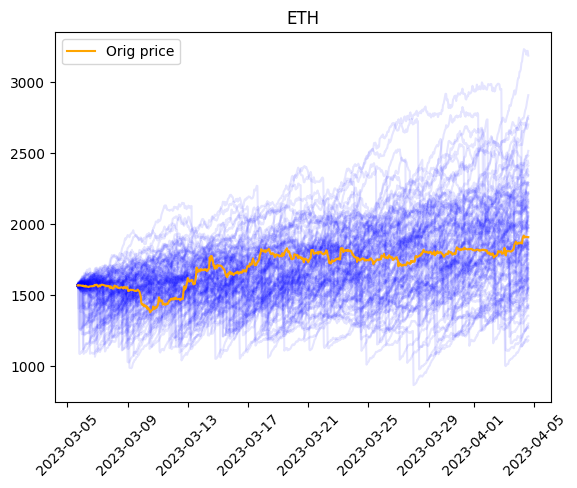

In [35]:
idx = 2
plt.title(list(tokens)[idx])
feed = PriceFeed(
    means[idx:idx + 1],
    covariations[idx:idx + 1, idx:idx + 1],
    np.ones((1, n_samples)) * prices[str(blocks[0])][tokens[idx]],
    jumps[idx:idx + 1], jump_probs[idx:idx + 1],
#     [1, 1, 1, 1, 1, 1, 1],
    jump_recoveries[idx:idx + 1],
)
values = [feed.current_state]
for _ in range(len(blocks) - 1):
    feed.next_step()
    values.append(feed.current_state)
plt.plot(ts, np.vstack(values), alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

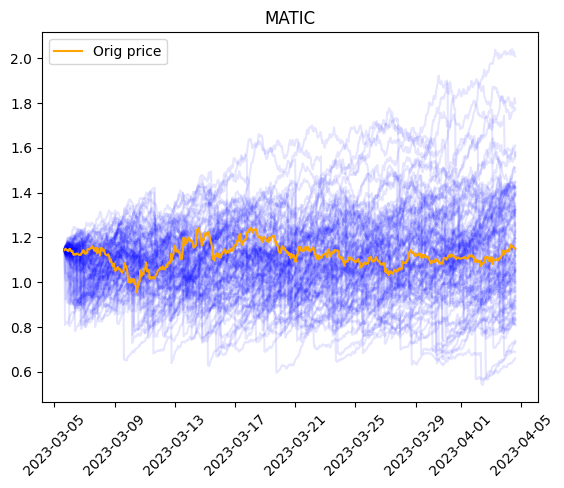

In [36]:
idx = 3
plt.title(list(tokens)[idx])
feed = PriceFeed(
    means[idx:idx + 1],
    covariations[idx:idx + 1, idx:idx + 1],
    np.ones((1, n_samples)) * prices[str(blocks[0])][tokens[idx]],
    jumps[idx:idx + 1], jump_probs[idx:idx + 1],
#     [1, 1, 1, 1, 1, 1, 1],
    jump_recoveries[idx:idx + 1],
)
values = [feed.current_state]
for _ in range(len(blocks) - 1):
    feed.next_step()
    values.append(feed.current_state)
plt.plot(ts, np.vstack(values), alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

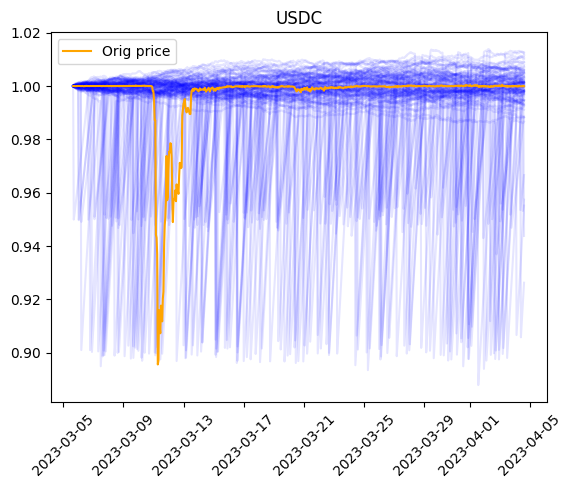

In [37]:
idx = 4
plt.title(list(tokens)[idx])
feed = PriceFeed(
    means[idx:idx + 1],
    covariations[idx:idx + 1, idx:idx + 1],
    np.ones((1, n_samples)) * prices[str(blocks[0])][tokens[idx]],
    jumps[idx:idx + 1], jump_probs[idx:idx + 1],
#     [1, 1, 1, 1, 1, 1, 1],
    jump_recoveries[idx:idx + 1],
)
values = [feed.current_state]
for _ in range(len(blocks) - 1):
    feed.next_step()
    values.append(feed.current_state)
plt.plot(ts, np.vstack(values), alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

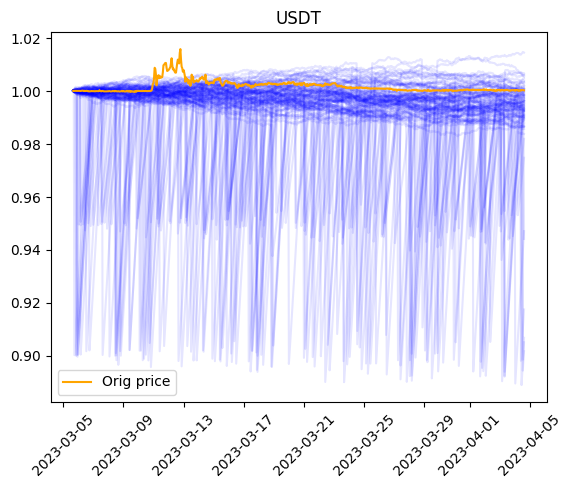

In [38]:
idx = 5
plt.title(list(tokens)[idx])
feed = PriceFeed(
    means[idx:idx + 1],
    covariations[idx:idx + 1, idx:idx + 1],
    np.ones((1, n_samples)) * prices[str(blocks[0])][tokens[idx]],
    jumps[idx:idx + 1], jump_probs[idx:idx + 1],
#     [1, 1, 1, 1, 1, 1, 1],
    jump_recoveries[idx:idx + 1],
)
values = [feed.current_state]
for _ in range(len(blocks) - 1):
    feed.next_step()
    values.append(feed.current_state)
plt.plot(ts, np.vstack(values), alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

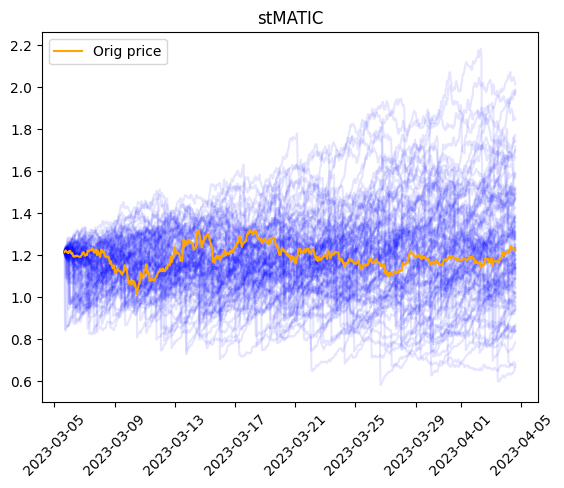

In [39]:
idx = 6
plt.title(list(tokens)[idx])
feed = PriceFeed(
    means[idx:idx + 1],
    covariations[idx:idx + 1, idx:idx + 1],
    np.ones((1, n_samples)) * prices[str(blocks[0])][tokens[idx]],
    jumps[idx:idx + 1], jump_probs[idx:idx + 1],
#     [1, 1, 1, 1, 1, 1, 1],
    jump_recoveries[idx:idx + 1],
)
values = [feed.current_state]
for _ in range(len(blocks) - 1):
    feed.next_step()
    values.append(feed.current_state)
plt.plot(ts, np.vstack(values), alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

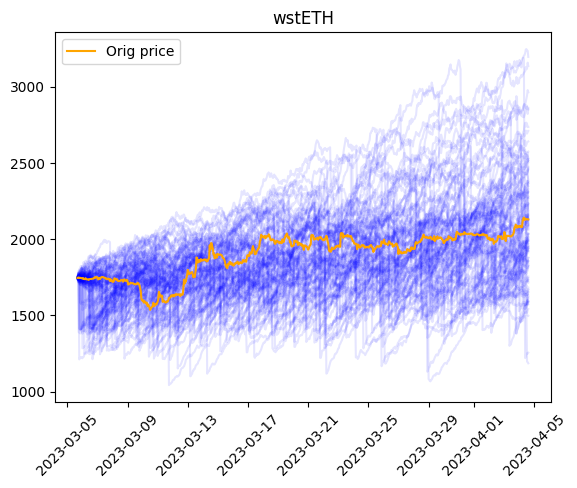

In [40]:
idx = 7
plt.title(list(tokens)[idx])
feed = PriceFeed(
    means[idx:idx + 1],
    covariations[idx:idx + 1, idx:idx + 1],
    np.ones((1, n_samples)) * prices[str(blocks[0])][tokens[idx]],
    jumps[idx:idx + 1], jump_probs[idx:idx + 1],
#     [1, 1, 1, 1, 1, 1, 1],
    jump_recoveries[idx:idx + 1],
)
values = [feed.current_state]
for _ in range(len(blocks) - 1):
    feed.next_step()
    values.append(feed.current_state)
plt.plot(ts, np.vstack(values), alpha=0.1, color='blue')
plt.plot(ts, [prices[str(block)][list(tokens)[idx]] for block in blocks], color='orange', label='Orig price')
plt.legend()
plt.xticks(rotation=45);

In [41]:
tokens

['BTC', 'DAI', 'ETH', 'MATIC', 'USDC', 'USDT', 'stMATIC', 'wstETH']

In [42]:
np.save('starting_values', [prices[str(blocks[0])][token] for token in tokens])